In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import importance_sampler_poise
import kl_divergence_calculator
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
import random
import umap
from tqdm import tqdm

importing Jupyter notebook from importance_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb


In [2]:
# def sample_data(mu1,mu2,var1,var2, nb_samples):
#     dim1 = mu1.size()[0]
#     dim2 = mu2.size()[0]
#     mn1  = torch.distributions.MultivariateNormal(mu1, var1 * torch.eye(dim1))
#     mn2  = torch.distributions.MultivariateNormal(mu2, var2 * torch.eye(dim2))
#     return [mn1.sample([nb_samples,]), mn2.sample([nb_samples,])]
# dim_exp = 2
# nb_samples=5000
# mu1  =5+torch.zeros(dim_exp)   
# var1 =1.0
# mu2  =-5+torch.zeros(dim_exp)   
# var2 =1.0
# data1,data2=sample_data(mu1,mu2,var1,var2,nb_samples)  

In [3]:
def sample_data(mu1,var1, nb_samples):
    dim1 = mu1.size()[0]
    mn1  = torch.distributions.MultivariateNormal(mu1, var1 * torch.eye(dim1))
    return [mn1.sample([nb_samples,])]
dim_exp = 2
nb_samples=5000
mu1  =8+torch.zeros(dim_exp)   
var1 =3.0
data1 = sample_data(mu1,var1,nb_samples) 
data1 = data1[0]
data2 = data1-16.0

In [4]:
# def sample(mu, var, nb_samples):
#     """
#     :param mu: torch.Tensor (features)
#     :param var: torch.Tensor (features) (note: zero covariance)
#     :return: torch.Tensor (nb_samples, features)
#     """
#     out = []
#     for i in range(nb_samples):
#         out += [torch.normal(mu, var.sqrt())]
#     return torch.stack(out, dim=0)
# ## Creating synthetic datasets
# nb_samples=5000
# mu1  =torch.tensor(0.)   # . converts long to float
# var1 =torch.tensor(1.0)
# mu2  =torch.tensor(0.)   # . converts long to float
# var2 =torch.tensor(1.0)

# inp_data1=sample(mu1,var1,nb_samples)  
# inp_data1=inp_data1.unsqueeze(0)+torch.randn_like(inp_data1)##Adding gaussian noise to data
# inp_data1=torch.transpose(inp_data1,0,1)

# inp_data2=sample(mu2,var2,nb_samples)
# inp_data2=inp_data2.unsqueeze(0)+torch.randn_like(inp_data2)  ##Adding gaussian noise to data
# inp_data2=torch.transpose(inp_data2,0,1)

In [5]:
# ## for data visualization
# data_vis1=inp_data1.numpy()
# data_vis2=inp_data2.numpy()
# fig, ax = plt.subplots(2,1)
# #flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
# #Panel a
# n1,bins1,patches1=ax[0].hist(data_vis1,'auto',density=1)
# y1=1/(np.sqrt(2*np.pi*var1))*np.exp(-0.5*(bins1-mu1.numpy())**2/var1)
# ax[0].plot(bins1,y1,'--')
# ax[0].set(xlabel='x',ylabel='p(x)')
# #Panel b
# n2,bins2,patches2=ax[1].hist(data_vis2,'auto',density=1)
# y2=1/(np.sqrt(2*np.pi*var2))*np.exp(-0.5*(bins2-mu2.numpy())**2/var2)
# ax[1].plot(bins2,y2,'--')
# ax[1].set(xlabel='x',ylabel='p(x)')
# plt.show()
# print("mu1",mu1)
# print("var1",var1)
# print("mu2",mu2)
# print("var2",var2)

In [6]:
# ## Transforming data to a higher dimension
# """
# inp_data= samplesx1
# fun_A   = 1xdim_exp
# data    = samplesxdim_exp   (data = inp_dataxfun_A)
# """
# dim_exp = 2
# #fun_A1   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
# #fun_A2   = torch.normal(0, 1, size=(1, dim_exp))  ## random tensor of size dim_expxdata_samples mean=0, var=1, s
# fun_A1 = torch.tensor([1,1])
# fun_A2 = torch.tensor([1,-1])
# data1    = inp_data1*fun_A1
# data2    = inp_data2*fun_A2
# x1_cord = data1[:,0]
# y1_cord = data1[:,1]
# x2_cord = data2[:,0]
# y2_cord = data2[:,1]
# plt.plot(x1_cord,y1_cord, 'o', color='black')
# plt.plot(x2_cord,y2_cord, 'o', color='red')
# plt.show()

In [7]:
# reducer = umap.UMAP()
# data=torch.vstack((data1,data2))
# embedding = reducer.fit_transform(data)
# fig, ax = plt.subplots(figsize=(12, 10))
# plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=4)
# plt.setp(ax, xticks=[], yticks=[])
# plt.gca().set_aspect('equal', 'datalim')
# # plt.title("SVHN data embedded into two dimensions by UMAP", fontsize=18)
# ax.set_facecolor('white')
# plt.show()

In [8]:
## Hyperparameters
batch_size = 128
latent_dim1 = 1
latent_dim2 = 1
lr         = 5e-4
device     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
## Creating synthetic dataloader
train_loader_set1 = DataLoader(
    data1[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set1 = DataLoader(
    data1[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
train_loader_set2 = DataLoader(
    data2[0:int(0.8*nb_samples),],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
test_loader_set2 = DataLoader(
    data2[int(0.8*nb_samples):,],
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [10]:
## Neural net is like: [mu,logvar]=(relu(xA))B,x=sig((relu(zC))D)        
class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.IS_sampler              = importance_sampler_poise.importance_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)
        self.n_IW_samples = 10
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.emb_dim  = 8
        ## Encoder set1
        self.set1_enc1 = nn.Linear(in_features = dim_exp,out_features =self.emb_dim)
        self.set1_enc2 = nn.Linear(in_features = self.emb_dim,out_features = 2*latent_dim1)
        ## Encoder set2
        self.set2_enc1 = nn.Linear(in_features = dim_exp,out_features = self.emb_dim)
        self.set2_enc2 = nn.Linear(in_features = self.emb_dim,out_features = 2*latent_dim2)
        ## Decoder set1
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = self.emb_dim)
        self.set1_dec2 = nn.Linear(in_features = self.emb_dim,out_features = dim_exp)
        ## Decoder set2
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = self.emb_dim)
        self.set2_dec2 = nn.Linear(in_features = self.emb_dim,out_features = dim_exp)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim1)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.g12   = torch.zeros(latent_dim1,latent_dim2).to(device)
    def weighted_mse_loss(self,weights,reconstruction,data):
        #weights :[batch_size], reconstruction: [batch_size,2], data: [batch_size,2] , loss: #
        loss = torch.sum(weights * ((data - reconstruction) ** 2).T)
        return loss
    def forward(self,x1,x2):
        data1    = x1
        data2    = x2
        ## encoding
# Modality 1
        x1       = (self.set1_enc1(x1))
        x1       = F.leaky_relu(self.set1_enc2(x1),inplace=True)
        mu1      = x1[:,0]
        mu1      = mu1.unsqueeze(0)
        mu1      = torch.transpose(mu1,0,1)    
        log_var1 = x1[:,1]
        log_var1 = log_var1.unsqueeze(0)
        log_var1 = torch.transpose(log_var1,0,1)    
        var1     = -torch.exp(log_var1)         # lambda_2<0
# Modality 2        
        x2       = (self.set2_enc1(x2))
        x2       = F.leaky_relu(self.set2_enc2(x2),inplace=True)        
        mu2      = x2[:,0]
        mu2      = mu2.unsqueeze(0)
        mu2      = torch.transpose(mu2,0,1)    
        log_var2 = x2[:,1]
        log_var2 = log_var2.unsqueeze(0)
        log_var2 = torch.transpose(log_var2,0,1) 
        var2     = -torch.exp(log_var2)           #lambdap_2<0
        g22      = -torch.exp(self.g22)        
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)
        z1_prior,z2_prior,z1_posterior,z2_posterior,IS_weights_prior,IS_weights_post = self.IS_sampler.calc(G,mu1,var1,mu2,var2,self.n_IW_samples)
        ## decoding
        loss = 0
        weighted_reconstruction1 = torch.zeros_like(data1)               #[batch_size,2]
        weighted_reconstruction2 = torch.zeros_like(data2)
        for i in range(self.n_IW_samples):
            self.z1_IS_prior     = z1_prior[i]
            self.z2_IS_prior     = z2_prior[i]
            self.z1_IS_posterior = z1_posterior[i]
            self.z2_IS_posterior = z2_posterior[i]
            part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_IS_posterior,self.z2_IS_posterior,self.z1_IS_prior,self.z2_IS_prior,mu1,var1,mu2,var2)
            x1                   = F.leaky_relu(self.set1_dec1(self.z1_IS_posterior.unsqueeze(0)),inplace=True)
            reconstruction1      = (self.set1_dec2(x1)).squeeze()
            x2                   = F.leaky_relu(self.set2_dec1(self.z2_IS_posterior.unsqueeze(0)),inplace=True)
            reconstruction2      = (self.set2_dec2(x2)).squeeze()
            ## loss
            MSE1 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction1, data1)
            MSE2 = self.weighted_mse_loss(IS_weights_post[i,:],reconstruction2, data2)
#             KLD  = torch.sum(IS_weights_post[i,:]*(torch.sum(part_fun0+part_fun1,dim=1)+part_fun2) )
            loss = loss + MSE1 + MSE2 
            weighted_reconstruction1 = weighted_reconstruction1 + (IS_weights_post[i,:]*reconstruction1.T).T
            weighted_reconstruction2 = weighted_reconstruction2 + (IS_weights_post[i,:]*reconstruction2.T).T
    
        return weighted_reconstruction1,weighted_reconstruction2,mu1,var1,mu2,var2,loss

In [11]:
model = VAE(latent_dim1, latent_dim2, batch_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias


In [12]:
def train(model,dataloader1,dataloader2):
    model.train()
    running_loss = 0
    for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
        data1                        = data1.to(device)
        data2                        = data2.to(device)   
        optimizer.zero_grad()
        reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss       = model(data1,data2)
        running_loss                += loss.item()
        loss.backward() 
        optimizer.step()
#         for p in model.parameters():
#             print(p.grad.norm())
    train_loss = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    return train_loss
def test(model,dataloader1,dataloader2):
    mean1_pred = []
    var1_pred  = []
    mean2_pred = []
    var2_pred  = []
    data1_val  = [] 
    data2_val  = [] 
    reconstruction1_pred=[]
    reconstruction2_pred=[]
    
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i,(data1,data2) in enumerate(zip(dataloader1,dataloader2)):
            data1                        = data1.to(device)
            data2                        = data2.to(device)        
            reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss = model(data1,data2)  
            running_loss              += loss.item()
            mean1_pred                += [torch.mean(mu1)]
            var1_pred                 += [torch.mean(var1)]
            mean2_pred                += [torch.mean(mu2)]
            var2_pred                 += [torch.mean(var2)]
            reconstruction1_pred.append(reconstruction1)
            reconstruction2_pred.append(reconstruction2)
            data1_val.append(data1)
            data2_val.append(data2)

    test_loss   = running_loss/(len(dataloader1.dataset)+len(dataloader2.dataset))
    reconstruction1_pred = torch.vstack(reconstruction1_pred)
    reconstruction2_pred = torch.vstack(reconstruction2_pred)
    data1_val   = torch.vstack(data1_val)
    data2_val   = torch.vstack(data2_val)

    mean1_pred  = torch.stack(mean1_pred,dim=0)
    var1_pred   = torch.stack(var1_pred,dim=0)
    mean1_pred  = torch.mean(mean1_pred)
    var1_pred   = torch.mean(var1_pred)
    mean2_pred  = torch.stack(mean2_pred,dim=0)
    var2_pred   = torch.stack(var2_pred,dim=0)
    mean2_pred  = torch.mean(mean2_pred)
    var2_pred   = torch.mean(var2_pred)
    return data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_loss,mean1_pred,var1_pred,mean2_pred,var2_pred

In [13]:
epochs     = 80
train_loss = []
test_loss = []
# all_data1 = torch.zeros(0,dim_exp)
# all_data2 = torch.zeros(0,dim_exp)
# all_reconstruction1 = torch.zeros(0,dim_exp)
# all_reconstruction2 = torch.zeros(0,dim_exp)

for epoch in tqdm(range(epochs)):
#     print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model,train_loader_set1,train_loader_set2)
    data1_val,data2_val,reconstruction1_pred,reconstruction2_pred,test_epoch_loss,mean1_pred,var1_pred,mean2_pred,var2_pred = test(model,test_loader_set1,test_loader_set2)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
#     for name, para in model.named_parameters():
#         print(para)
print(f"Train Loss    : {train_epoch_loss:.4f}")
print(f"Test Loss     :  {test_epoch_loss:.4f}")
print(f"Mean Pred set1:  {mean1_pred:.4f}")
print(f"Var  Pred set1:  {var1_pred:.4f}")
print(f"Mean Pred set2:  {mean2_pred:.4f}")
print(f"Var  Pred set2:  {var2_pred:.4f}")

100%|██████████| 80/80 [03:53<00:00,  2.92s/it]

Train Loss    : 7.6796
Test Loss     :  6.7902
Mean Pred set1:  11.3243
Var  Pred set1:  -2.4169
Mean Pred set2:  2.5028
Var  Pred set2:  -1.1334


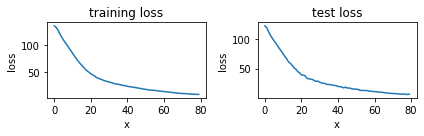

In [18]:
flg,(ax1,ax2)=plt.subplots(1,2,figsize=(6, 2))
ax1.plot(train_loss)
ax1.set(xlabel='x',ylabel='loss',title='training loss')
ax2.plot(test_loss)
ax2.set(xlabel='x',ylabel='loss',title='test loss')
flg.tight_layout()
plt.show()

In [19]:
reducer = umap.UMAP()
data=torch.vstack((reconstruction1_pred.cpu(),reconstruction2_pred.cpu()))
embedding = reducer.fit_transform(data)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
#plt.title("SVHN data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [20]:
reconstruction1_pred = reconstruction1_pred.cpu().detach().numpy()
reconstruction2_pred = reconstruction2_pred.cpu().detach().numpy()
# reconstruction1_pred =np.reshape(reconstruction1_pred.cpu().detach().numpy(),(896,2))
# reconstruction2_pred =np.reshape(reconstruction2_pred.cpu().detach().numpy(),(896,2))
# reconstruction1_pred =np.reshape(reconstruction1_pred,(896,2))
# reconstruction2_pred =np.reshape(reconstruction2_pred,(896,2))
reconstruction1_x_cord = reconstruction1_pred[:,0]
reconstruction1_y_cord = reconstruction1_pred[:,1]
reconstruction2_x_cord = reconstruction2_pred[:,0]
reconstruction2_y_cord = reconstruction2_pred[:,1]
data1_x_cord = data1_val[:,0].cpu().detach().numpy()
data1_y_cord = data1_val[:,1].cpu().detach().numpy()
data2_x_cord = data2_val[:,0].cpu().detach().numpy()
data2_y_cord = data2_val[:,1].cpu().detach().numpy()

fig, ax = plt.subplots(2)

ax[0].plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
ax[0].plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
ax[0].legend()
ax[1].plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='black',label='recon set1')
ax[1].plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='red',label='recon set2')
ax[1].legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

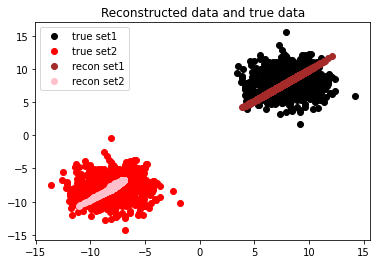

In [21]:
plt.plot(data1_x_cord,data1_y_cord, 'o', color='black',label='true set1')
plt.plot(data2_x_cord,data2_y_cord, 'o', color='red',label='true set2')
plt.plot(reconstruction1_x_cord,reconstruction1_y_cord, 'o', color='brown',label='recon set1')
plt.plot(reconstruction2_x_cord,reconstruction2_y_cord, 'o', color='pink',label='recon set2')
plt.title('Reconstructed data and true data')
plt.legend()
plt.show()